In [ ]:
import pandas as pd
import numpy as np
import os, sys
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt

from my_awesome_eda import run_eda
import plotly.express as px
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
DATA_PATH = "../data"

Будем учиться классифицировать жанры музыки, полузуюсь не аудио дорожками, а уже осмысленными признаками (правда, не все из них имеют понятные названия). Сами данные можно найти [здесь](https://www.kaggle.com/purumalgi/music-genre-classification). Будем использовать файл `train.csv`. Нашей задачей будет предсказание переменной `Class` (жанр песни) при помощи деревьев решений. Можно попробовать также другие методы классификации, которые мы прошли, и сравнить результаты. При обучении всех моделей не забывайте про разделение на тренировку и тест (или кросс валидацию [ссылка](https://www.youtube.com/watch?v=fSytzGwwBVw)).

### Задание 1. EDA (10 баллов)

Как обычно, начнем с того, что посмотрим на наши данные: типы переменных, пропущенные значения, баланс классов и все такое. Ваш ход:

In [ ]:
data = pd.read_csv(os.path.join(DATA_PATH, "train.csv"))
data.head()

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,0.8990,134.071,234596.0,4,5
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.0,4,10
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.0,4,6
3,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,0.5690,107.033,173968.0,4,5
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.0,4,10


Hi! I will give you some basic summary of your  dataset. 
   Shape: 17996 rows x 17 columns 


***** Data Types in Columns *****
Artist Name             object
Track Name              object
Popularity            category
danceability          category
energy                category
key                   category
loudness               float64
mode                  category
speechiness           category
acousticness           float64
instrumentalness       float64
liveness              category
valence               category
tempo                  float64
duration_in min/ms     float64
time_signature        category
Class                 category




***** Main Statistics on Categorical Columns ***** 
                counts  frequencies
Popularity         100     0.005557
danceability       909     0.050511
energy            1208     0.067126
key                 11     0.000611
mode                 2     0.000111
speechiness       1194     0.066348
liveness          1459     0.081074


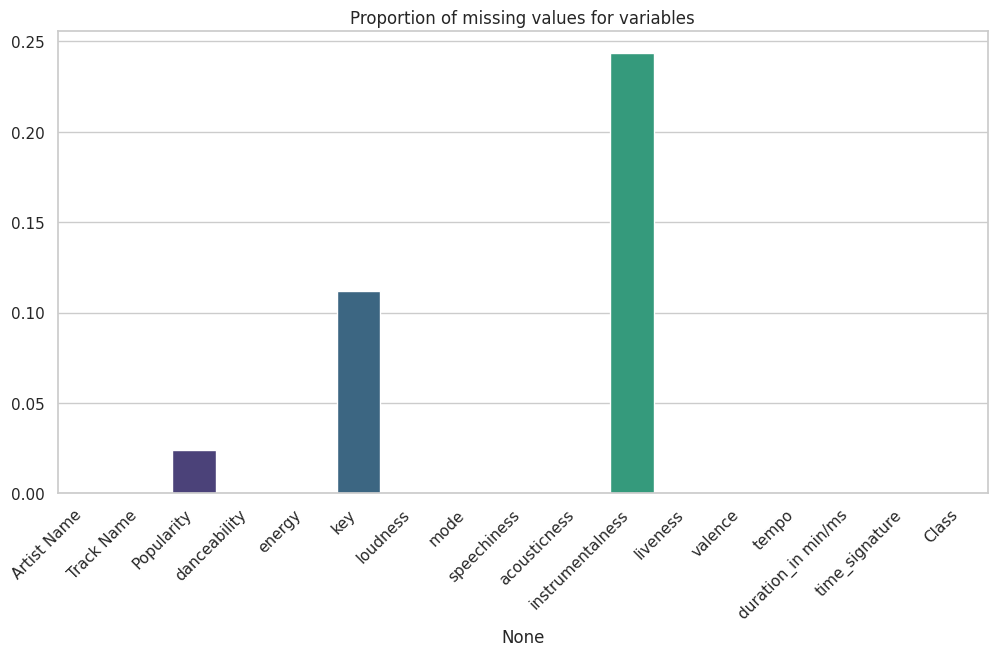

Quantity of  rows with missing values: 6183
Columns with missing values: ['Popularity', 'key', 'instrumentalness']
Duplicate rows in df: 0


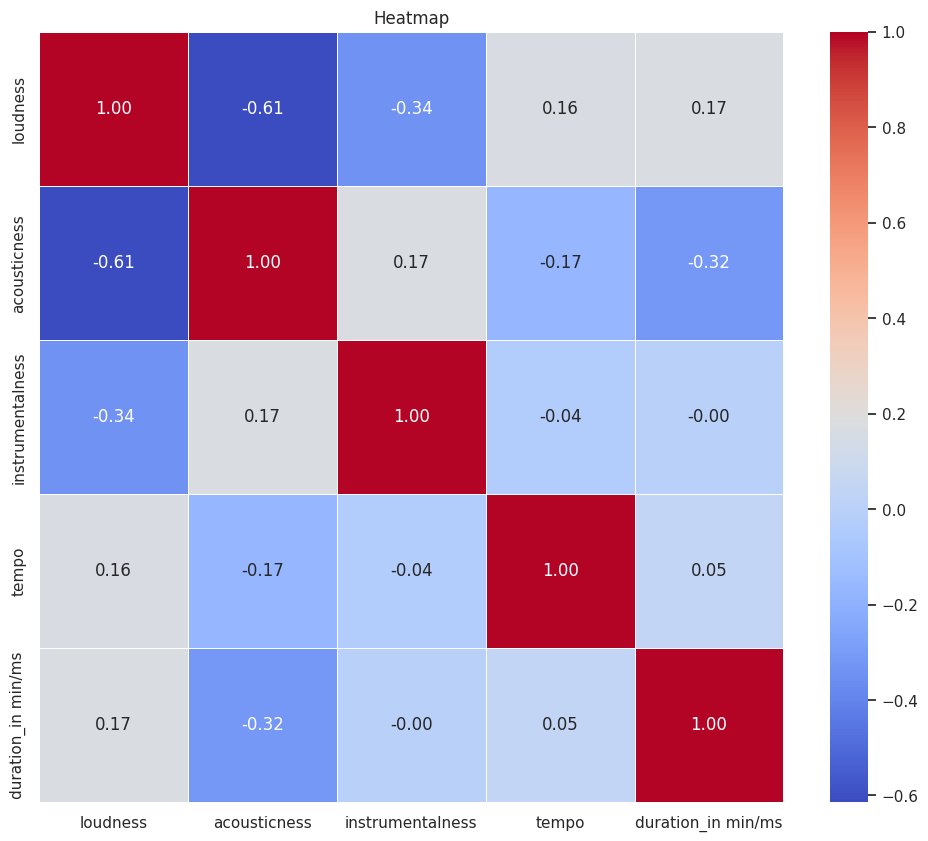

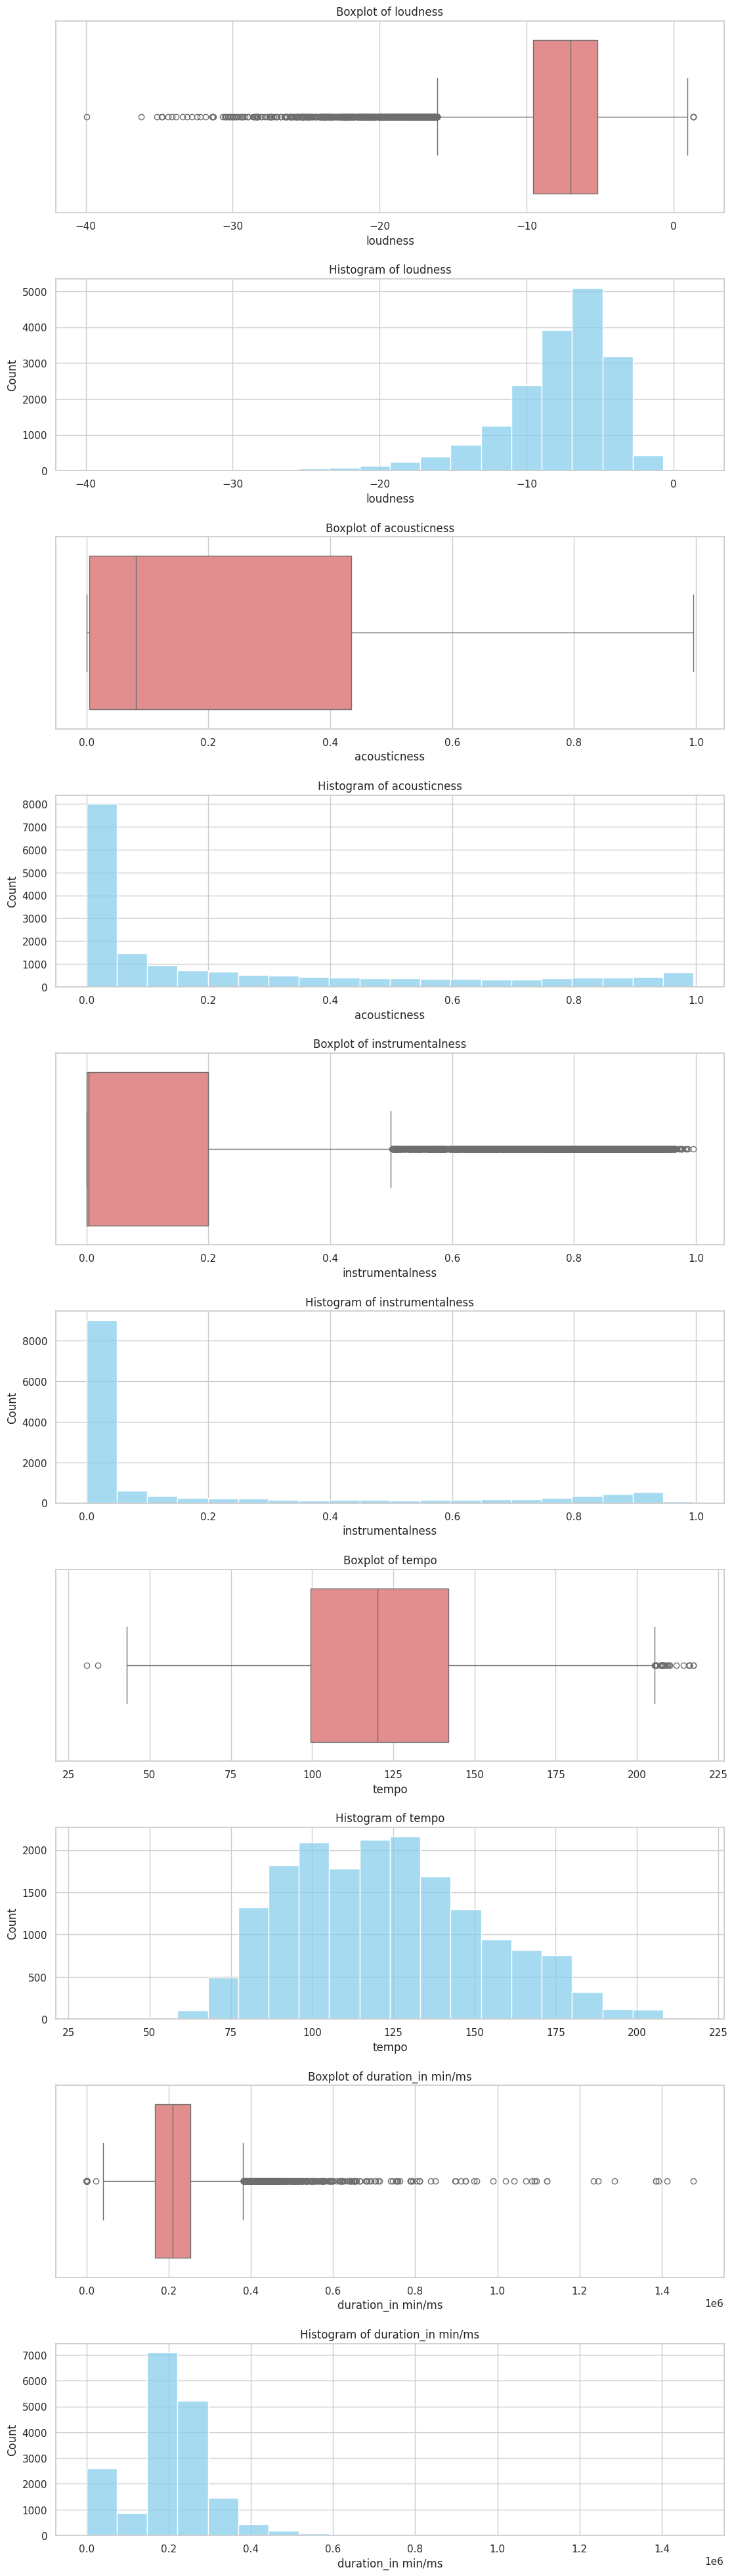

In [ ]:
run_eda(data)

In [ ]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
loudness,17996.0,-7.910660,4.049151,-39.952000,-9.538000,-7.01600,-5.18900,1.355
acousticness,17996.0,0.247082,0.310632,0.000000,0.004300,0.08140,0.43400,0.996
instrumentalness,13619.0,0.177562,0.304048,0.000001,0.000089,0.00391,0.20000,0.996
tempo,17996.0,122.623294,29.571527,30.557000,99.620750,120.06550,141.96925,217.416
duration_in min/ms,17996.0,200744.458851,111989.127131,0.501650,166337.000000,209160.00000,252490.00000,1477187.000


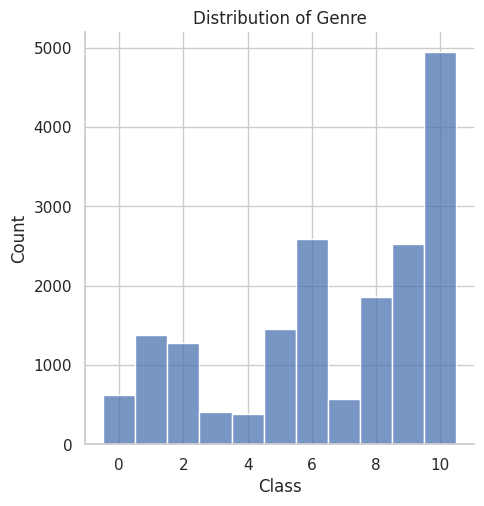

In [ ]:
sns.displot(data['Class'])
plt.title(f'Distribution of Genre')
plt.show()

In [ ]:
genre_counts = data['Class'].value_counts().reset_index()
genre_counts.columns = ['Genre', 'Count']
fig = px.pie(genre_counts, names='Genre', values='Count', title='Genre Distribution Pie Chart',color_discrete_sequence=px.colors.sequential.PuRd)
fig.show()

In [ ]:
data['Artist Name'].nunique()

9149

In [ ]:
data['Track Name'].nunique()

15129

Почти все имена треков являются уникальными, так что их стоит удалить, ведь деревья склонны к переобучению и просто может сделать свои "листья" для каждой композиции. Также, как мне кажется, стоит удалить и автора, ведь мы хотим предсказать жанр не по автору (каждый из которых, скорее всего, работае в своем жанре. Скорее всего уникальных имен меньше - просто потому что имена сами по себе как явление часто повторятся (с) Настя)

In [ ]:
data['Artist Name'] = data['Artist Name'].astype('category')
data['Class'] = data['Class'].astype('category')

In [ ]:
data.groupby(by='Class')['Artist Name', 'Track Name'].count()

,Artist Name,Track Name
Class,,
0,625,625
1,1373,1373
2,1272,1272
3,402,402
4,387,387
5,1447,1447
6,2587,2587
7,576,576
8,1854,1854


Кажется, это дествительно так. Удаляем

In [ ]:
data = data.drop(columns=['Artist Name', 'Track Name'])
data

,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,0.8990,134.071,234596.0,4,5
1,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.0,4,10
2,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.0,4,6
3,66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,0.5690,107.033,173968.0,4,5
4,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.0,4,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17991,35.0,0.166,0.109,7.0,-17.100,0,0.0413,0.993000,0.824000,0.0984,0.1770,171.587,193450.0,3,6
17992,27.0,0.638,0.223,11.0,-10.174,0,0.0329,0.858000,0.000016,0.0705,0.3350,73.016,257067.0,4,2
17993,34.0,0.558,0.981,4.0,-4.683,0,0.0712,0.000030,0.000136,0.6660,0.2620,105.000,216222.0,4,8
17994,29.0,0.215,0.805,6.0,-12.757,0,0.1340,0.001290,0.916000,0.2560,0.3550,131.363,219693.0,4,8


Разберемся с минутами и милисекундами

<Axes: xlabel='duration_in min/ms', ylabel='Density'>

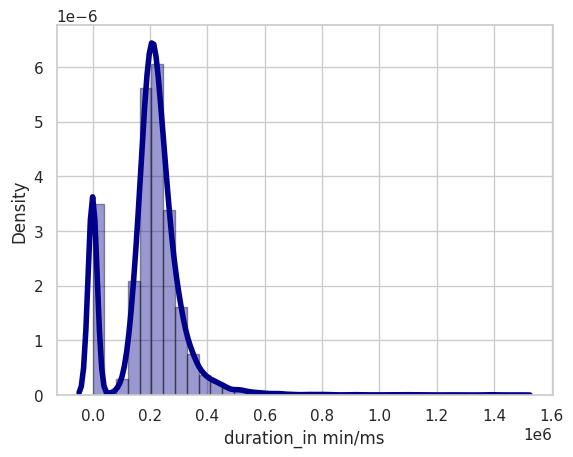

In [ ]:
sns.distplot(data['duration_in min/ms'], hist=True, kde=True,
             bins=int(180/5), color = 'darkblue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

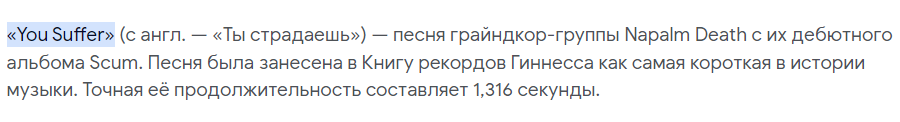

Кажется, часть данных значительно меньше. Значит эти песни в минутах! :)

In [ ]:
treshold = 1.316*1000
data['duration_ms'] = np.where(data['duration_in min/ms']<=treshold, data['duration_in min/ms']*60*1000, data['duration_in min/ms'])
data = data.drop(columns=['duration_in min/ms'])

<Axes: xlabel='duration_ms', ylabel='Density'>

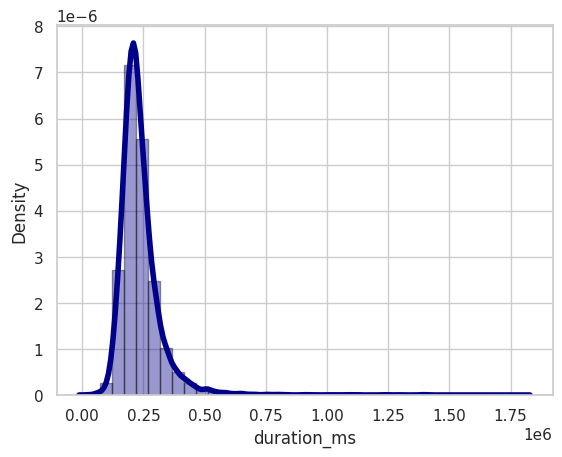

In [ ]:
sns.distplot(data['duration_ms'], hist=True, kde=True,
             bins=int(180/5), color = 'darkblue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

Время заполнить NA - их достаточно много, особенно у признака instrumentalness

In [ ]:
np.arange(0.0, 1.0, 0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

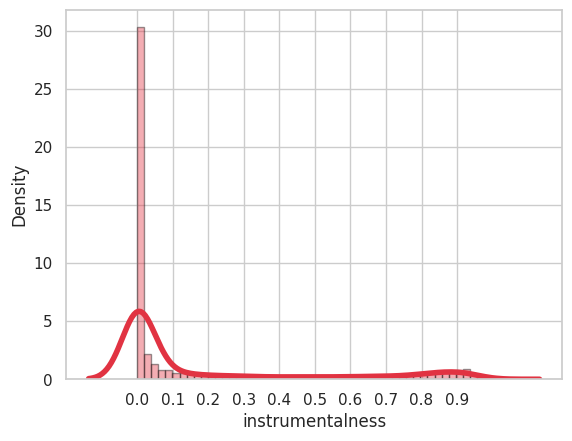

In [ ]:
sns.distplot(data['instrumentalness'], hist=True, kde=True,
             bins=int(50), color = sns.color_palette("rocket")[3],
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
desired_xticks = np.arange(0.0, 1.0, 0.1)
plt.xticks(desired_xticks);

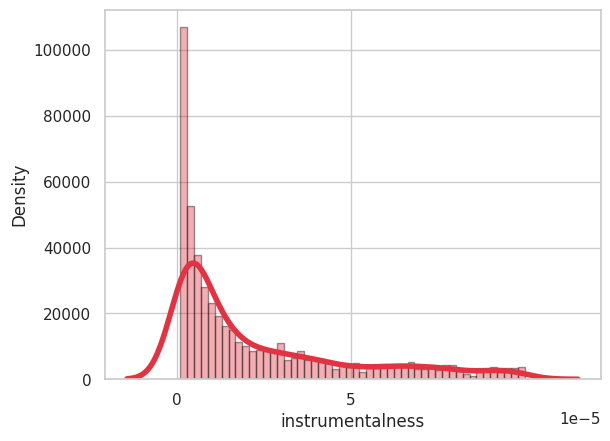

In [ ]:
sns.distplot(data[data['instrumentalness']<0.0001]['instrumentalness'], hist=True, kde=True,
             bins=int(50), color = sns.color_palette("rocket")[3],
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
desired_xticks = np.arange(0.0, 0.0001, 0.00005)
plt.xticks(desired_xticks);

In [ ]:
data['instrumentalness_low'] = np.where(data["instrumentalness"]<0.05, 1,0)
data['instrumentalness_high'] = np.where(data["instrumentalness"]<1, 1,0)
data['instrumentalness_classes'] = data['instrumentalness_low']+data['instrumentalness_high']

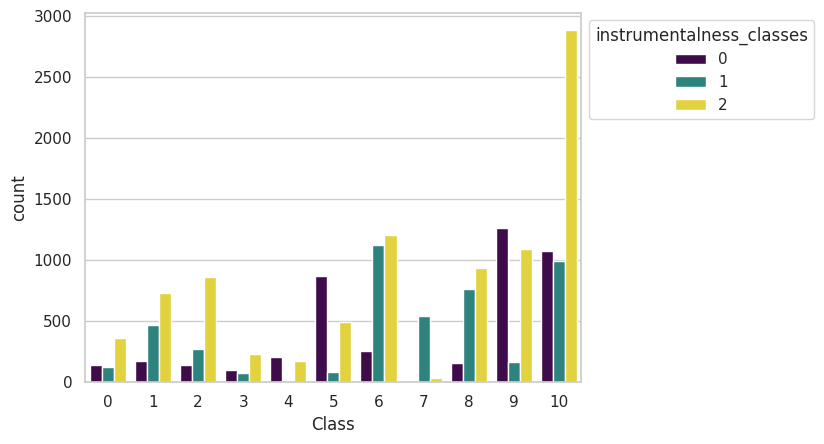

In [ ]:
ax = sns.countplot(data=data, x='Class',
            hue='instrumentalness_classes', palette='viridis',
           );

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


Кажется, тут стоит только выделить столбец, значения которого около нуля. Поэтому данные заполню медианой - чтобы не делать выбросы и смещение в сторону этого 0

In [ ]:
median = data["instrumentalness"].median()
data["instrumentalness"] =  data["instrumentalness"].fillna(median)

<Axes: xlabel='instrumentalness', ylabel='Density'>

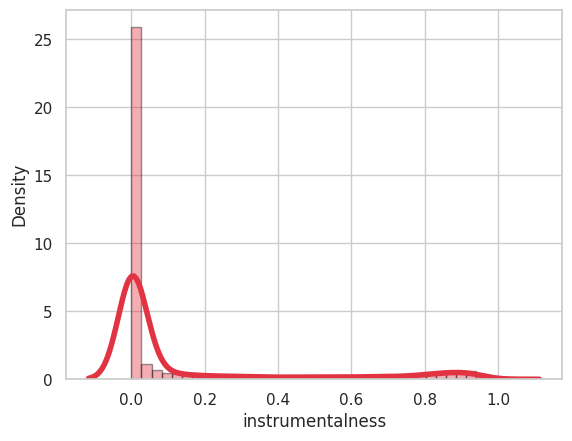

In [ ]:
sns.distplot(data['instrumentalness'], hist=True, kde=True,
             bins=int(180/5), color = sns.color_palette("rocket")[3],
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

In [ ]:
data['instrumentalness_low'] = np.where(data["instrumentalness"]<0.05, 1,0)
data['instrumentalness_high'] = np.where(data["instrumentalness"]<1, 1,0)
data['instrumentalness_classes'] = data['instrumentalness_low']+data['instrumentalness_high']

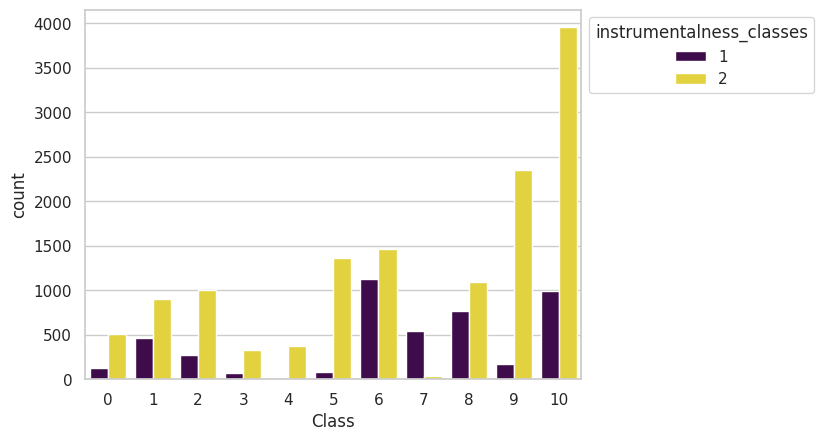

In [ ]:
ax = sns.countplot(data=data, x='Class',
            hue='instrumentalness_classes', palette='viridis',
           );

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


Ура, пропорции внутри классов сохранены. В будущем попробуем построить модели для двух вариантов -числового и дискретного

In [ ]:
data = data.drop(columns=['instrumentalness_low','instrumentalness_high'])

In [ ]:
type(data['Popularity'][0])

numpy.float64

<Axes: xlabel='Popularity', ylabel='Density'>

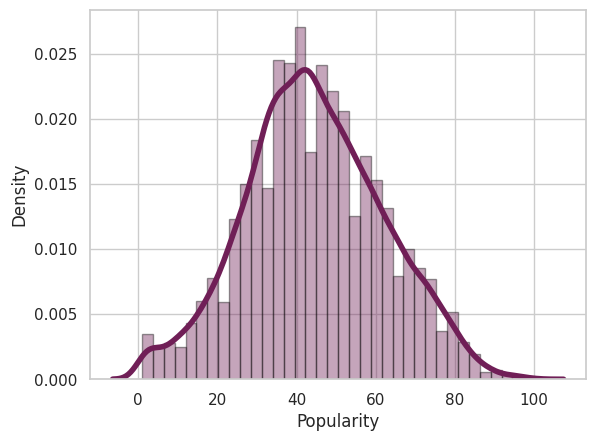

In [ ]:
sns.distplot(data['Popularity'], hist=True, kde=True,
             bins=int(180/5), color = sns.color_palette("rocket")[1],
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

In [ ]:
data["Popularity"].mode()

0    42.0
Name: Popularity, dtype: category
Categories (100, float64): [1.0, 2.0, 3.0, 4.0, ..., 97.0, 98.0, 99.0, 100.0]

In [ ]:
data["Popularity"].astype('float').mean()

44.51212431693989

Это поле вполне можно заполнить средним или модой, заполним модой, так как по умолчанию тип стоит категориальный

In [ ]:
mode = data["Popularity"].mode()
data["Popularity"] = data["Popularity"].fillna(mode[0])

<Axes: xlabel='Popularity2', ylabel='Density'>

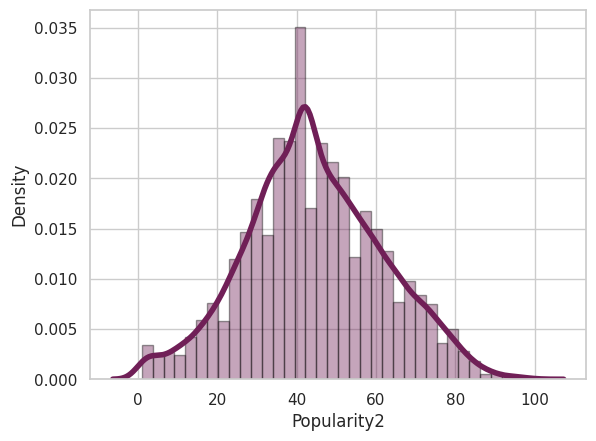

In [ ]:
sns.distplot(data['Popularity'], hist=True, kde=True,
             bins=int(180/5), color = sns.color_palette("rocket")[1],
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

key - дискретные значения

<Axes: xlabel='key', ylabel='Density'>

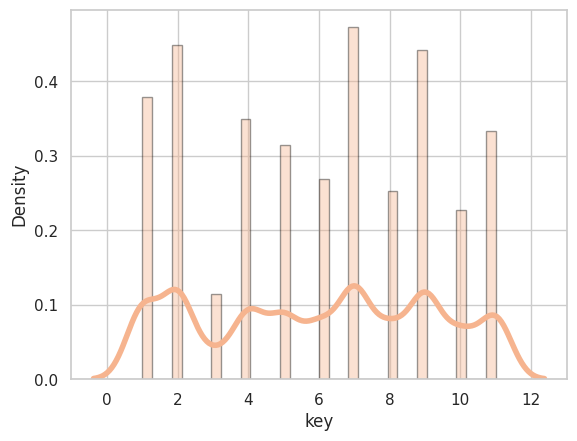

In [ ]:
sns.distplot(data['key'], hist=True, kde=True,
             bins=int(180/5), color = sns.color_palette("rocket")[5],
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

Для этих данных - заполним модой

In [ ]:
mode = data["key"].mode()
data["key2"] = data["key"].fillna(mode[0])

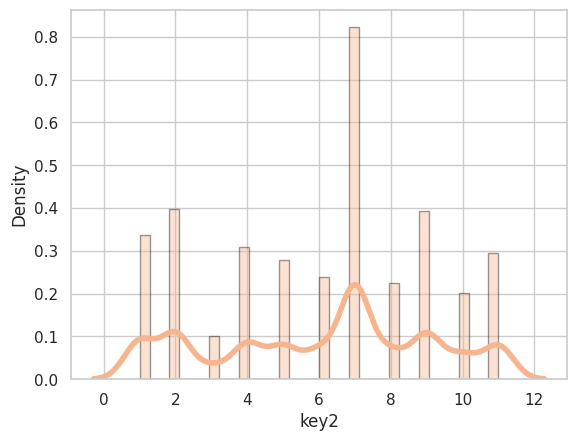

In [ ]:
sns.distplot(data['key2'], hist=True, kde=True,
             bins=int(180/5), color = sns.color_palette("rocket")[5],
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
data = data.drop(columns=["key2"])

In [ ]:
sum(pd.isna(data["key"]))

2014

Заполнение модой слишком сильно меняет баланс между классами. Лучше просто удалить эти значения NA - их не так много - всего 2 тысячи из 17 тысяч

In [ ]:
data = data.dropna()
data.shape

(15613, 17)

### Задание 2. Обучение дерева решений (10 баллов)

Предобработайте признаки так, чтобы их можно было подать в модель дерева решений и обучите ее, постарайтесь подобрать оптимальные гиперпараметры, которые вам известны. Постарайтесь также обосновать выбор метрики в данном случае. При подборе гиперпараметров может помочь `GridSearchCV` [ссылка](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [ ]:
from numpy import mean
from numpy import std
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import accuracy_score, auc, log_loss, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score, ConfusionMatrixDisplay, top_k_accuracy_score

In [ ]:
# X['key'] = X['key'].cat.add_categories('0')
# X['key'].fillna('0', inplace =True)
X = data.drop(columns=['instrumentalness_classes', 'Class'])

y = data['Class']

Так как монотонные преобразования не меняют дерево, стандартизацию признаков делать не буду

In [ ]:
#обязательно ставим stratify, чтобы и в train и в test было одинаковое распределение классов
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

Чтобы различить 10 классов надо ставить глубину минимум 4. С неё и начнем

In [ ]:
data.drop(columns=['instrumentalness_classes', 'Class']).columns.to_list()


['Popularity',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'time_signature',
 'duration_ms']

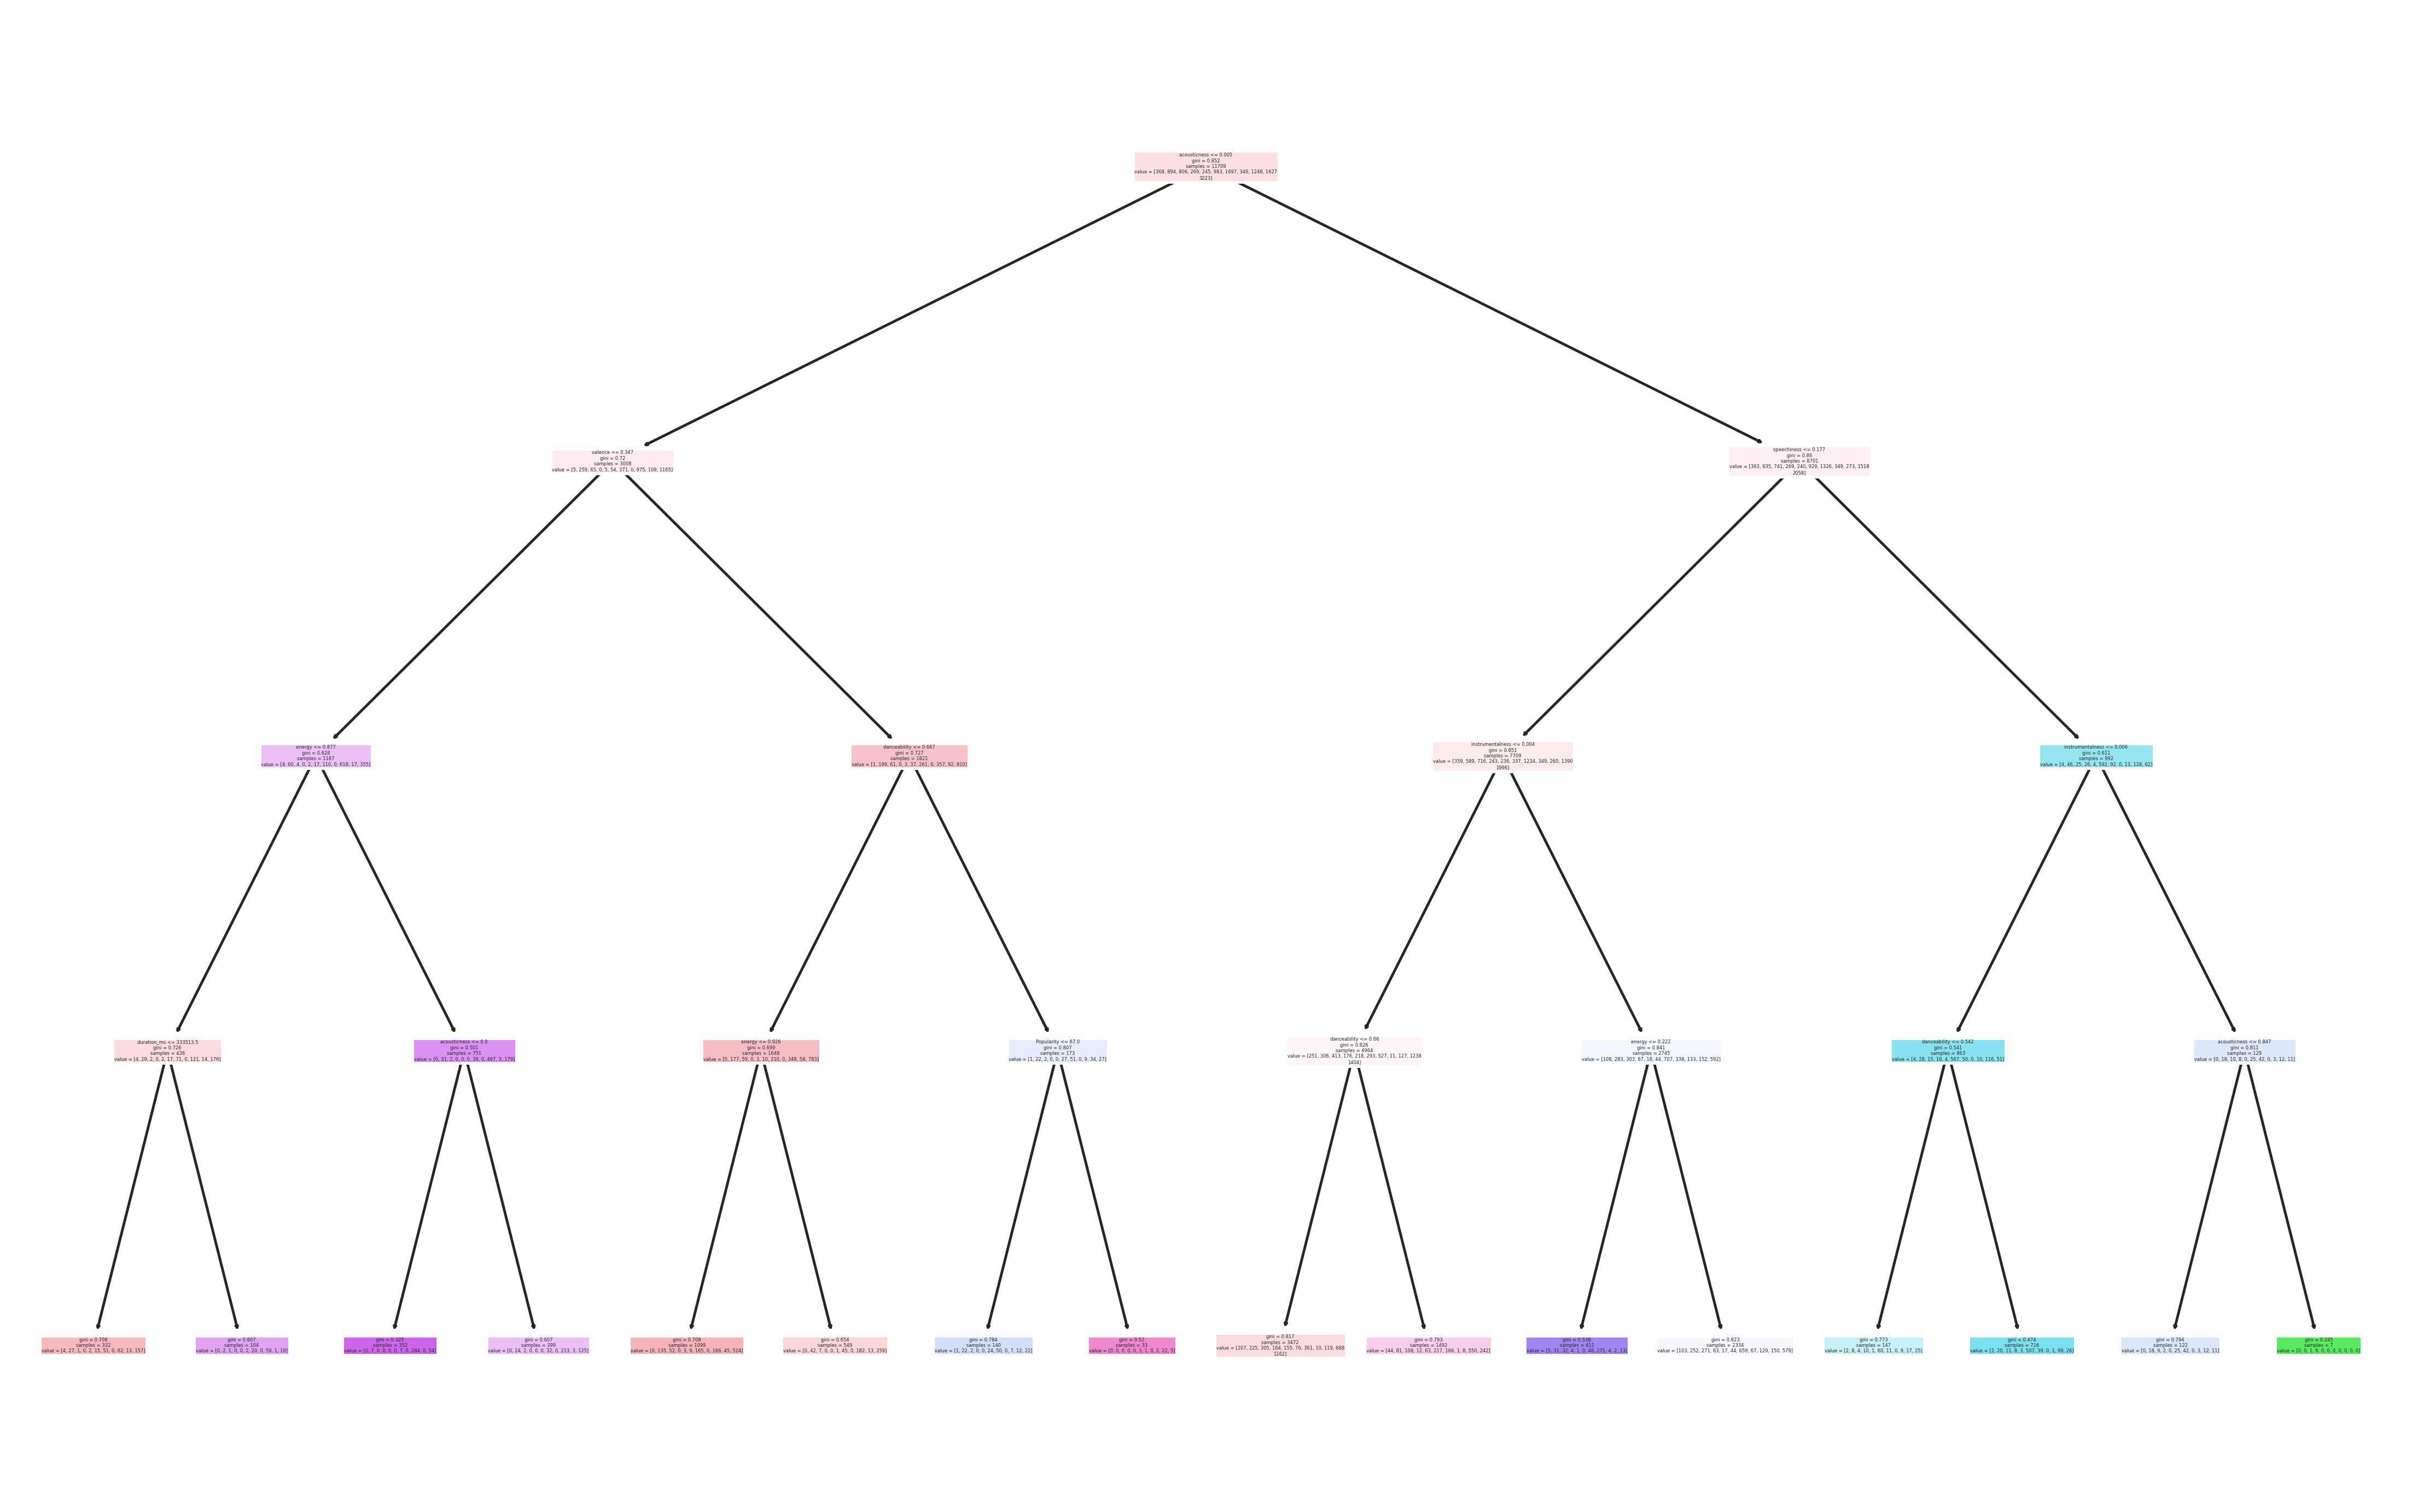

In [ ]:
clf = DecisionTreeClassifier(max_depth=4)
clf.fit(X_train, y_train)


fn = data.drop(columns=['instrumentalness_classes', 'Class']).columns.to_list()

# cn = ["versicolor", "setosa&virginica"]
plt.figure(figsize =(16, 10), dpi=350)
# fig, axes = plt.subplots(nrows=1, ncols=2,
#                          figsize=(16, 6), dpi=150)
tree.plot_tree(clf,
               feature_names=fn,
              #  class_names=cn,
               filled=True);
# plt.show()

TRAIN
Accuracy: 0.41
f1_score: 0.28
TEST
Accuracy: 0.40
f1_score: 0.28


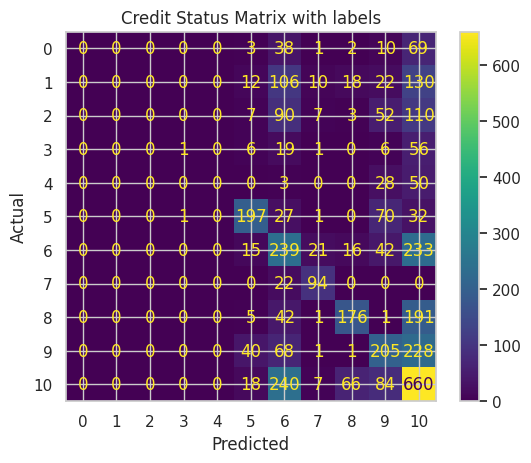

In [ ]:
y_pred = clf.predict(X_test)
probs = clf.predict_proba(X_test)[:,1]

train_probs = clf.predict_proba(X_train)[:,1]
train_predictions = clf.predict(X_train)
cm = confusion_matrix(y_train, train_predictions)
print('TRAIN')
print('Accuracy: %.2f' % (accuracy_score(y_train, train_predictions)))
print('f1_score: %.2f' % (f1_score(y_train, train_predictions,average="macro")))

print('TEST')
cm = confusion_matrix(y_test, y_pred)
#общая точность
print('Accuracy: %.2f' % (accuracy_score(y_test, y_pred)))
print('f1_score: %.2f' % (f1_score(y_test, y_pred,average="macro")))
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['0','1','2','3','4','5','6','7','8','9','10'])
cmd_obj.plot()
cmd_obj.ax_.set(
                title='Credit Status Matrix with labels',
                xlabel='Predicted',
                ylabel='Actual')
plt.show();

In [ ]:
y_train.unique()

[6, 10, 1, 8, 9, ..., 7, 3, 2, 0, 5]
Length: 11
Categories (11, int64): [0, 1, 2, 3, ..., 7, 8, 9, 10]

In [ ]:
pd.Series(train_predictions).unique()

array([10,  9,  6,  8,  5,  7,  2,  3,  1,  4,  0])

Попробую увеличить глубину. Тут и показатели плохие, и даже не все классы у тренировочной выборки предсаказались

TRAIN
Accuracy: 0.50
f1_score: 0.41
TEST
Accuracy: 0.45
f1_score: 0.35


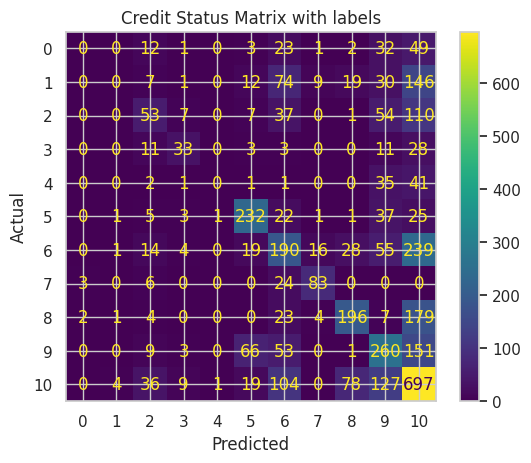

In [ ]:
clf2 = DecisionTreeClassifier(max_depth=8 )
clf2.fit(X_train, y_train)
y_pred = clf2.predict(X_test)
probs = clf2.predict_proba(X_test)[:,1]

train_probs = clf2.predict_proba(X_train)[:,1]
train_predictions = clf2.predict(X_train)
cm = confusion_matrix(y_train, train_predictions)
print('TRAIN')
print('Accuracy: %.2f' % (accuracy_score(y_train, train_predictions)))
print('f1_score: %.2f' % (f1_score(y_train, train_predictions,average="macro")))

print('TEST')
cm = confusion_matrix(y_test, y_pred)
#общая точность
print('Accuracy: %.2f' % (accuracy_score(y_test, y_pred)))
# print('K-accuracy: %.2f' % (top_k_accuracy_score(y_test, y_pred)))
print('f1_score: %.2f' % (f1_score(y_test, y_pred,average="macro")))
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['0','1','2','3','4','5','6','7','8','9','10'])
cmd_obj.plot()
cmd_obj.ax_.set(
                title='Credit Status Matrix with labels',
                xlabel='Predicted',
                ylabel='Actual')
plt.show();

In [ ]:
y_train.unique()

[6, 10, 1, 8, 9, ..., 7, 3, 2, 0, 5]
Length: 11
Categories (11, int64): [0, 1, 2, 3, ..., 7, 8, 9, 10]

In [ ]:
pd.Series(train_predictions).unique()

array([ 1,  3,  4,  6,  8, 10,  9,  5,  7,  0,  2])

In [ ]:
y_test.unique()

[1, 6, 8, 9, 5, ..., 2, 4, 0, 3, 7]
Length: 11
Categories (11, int64): [0, 1, 2, 3, ..., 7, 8, 9, 10]

In [ ]:
pd.Series(y_pred).unique()

array([10,  8,  9,  5,  6,  2,  7,  3,  1,  4,  0])

Все еще не очень, но уже лушче. Все классы есть, ура! Но это и повод освоить GridSearchCV - поиск оптимального параметра на решетке с помощью кросс-валидации

In [ ]:
parameters_grid = {
    'min_samples_split' : [2, 3, 4, 5, 7, 10],
    'max_features' : ["auto", "sqrt", "log2"],
    'class_weight': ["balanced", "balanced_subsample"],
    'max_depth': np.arange(4, 15, 1),
    'min_samples_leaf': [2, 3, 4, 5, 7, 10] #1,
}

lr = DecisionTreeClassifier()
# cv = StratifiedKFold(n_splits=3, shuffle=True)
grid_cv = GridSearchCV(lr, parameters_grid,
                       scoring='accuracy', cv=2, verbose=0)
grid_cv.fit(X_train, y_train);
print(grid_cv.best_score_)
print(grid_cv.best_params_)
best_params = grid_cv.best_params_

model = DecisionTreeClassifier(**best_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
probs = model.predict_proba(X_test)[:,1]

train_probs = model.predict_proba(X_train)[:,1]
train_predictions = model.predict(X_train)

print('Accuracy: %.2f' % (accuracy_score(y_test, y_pred)))

In [ ]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

0.32667137755990705
{'class_weight': 'balanced', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3}


Для Grid я использовала максимизирование двух метрик и вот результаты по ним:
> f1 = {'class_weight': 'balanced', 'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2}
Accuracy: 0.23

> accuracy = {'class_weight': 'balanced', 'max_depth': 13, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2}
Accuracy: 0.32

Я использовала именно их, так как я люблю разную музыку и разница в жанре мне не важна :D

Если серъезно, то правда нам нет разницы в том, какой жанр предсказывать - их важность одинакова. Поэтому можно ориентироваться либо на accuracy, либо на f1.




Очень странно, метрики ниже чем у дерева выше. Попробую grid только дл max_depth

In [ ]:
parameters_grid = {
    'max_depth': np.arange(4, 15, 1)
}

lr = DecisionTreeClassifier()
# cv = StratifiedKFold(n_splits=3, shuffle=True)
grid_cv = GridSearchCV(lr, parameters_grid,
                       scoring='accuracy', cv=2, verbose=3)
grid_cv.fit(X_train, y_train);
print(grid_cv.best_score_)
print(grid_cv.best_params_)
best_params = grid_cv.best_params_

model = DecisionTreeClassifier(**best_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
probs = model.predict_proba(X_test)[:,1]

train_probs = model.predict_proba(X_train)[:,1]
train_predictions = model.predict(X_train)

print('Accuracy: %.2f' % (accuracy_score(y_test, y_pred)))

Fitting 2 folds for each of 11 candidates, totalling 22 fits
[CV 1/2] END .......................max_depth=4;, score=0.399 total time=   0.1s
[CV 2/2] END .......................max_depth=4;, score=0.383 total time=   0.1s
[CV 1/2] END .......................max_depth=5;, score=0.409 total time=   0.1s
[CV 2/2] END .......................max_depth=5;, score=0.405 total time=   0.1s
[CV 1/2] END .......................max_depth=6;, score=0.414 total time=   0.1s
[CV 2/2] END .......................max_depth=6;, score=0.410 total time=   0.1s
[CV 1/2] END .......................max_depth=7;, score=0.416 total time=   0.1s
[CV 2/2] END .......................max_depth=7;, score=0.416 total time=   0.1s
[CV 1/2] END .......................max_depth=8;, score=0.411 total time=   0.1s
[CV 2/2] END .......................max_depth=8;, score=0.409 total time=   0.1s
[CV 1/2] END .......................max_depth=9;, score=0.409 total time=   0.1s
[CV 2/2] END .......................max_depth=9;

Так, все же результат grid search дают на 0.1 accuracy меньше
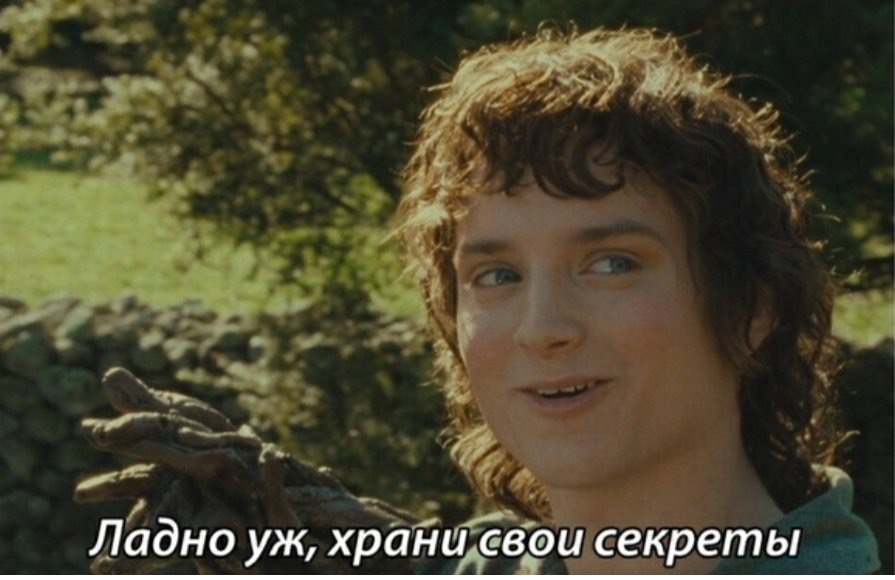

TRAIN
Accuracy: 0.48
f1_score: 0.38
TEST
Accuracy: 0.44
f1_score: 0.34


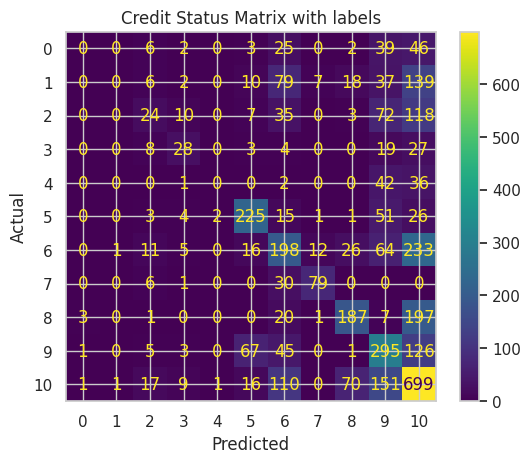

In [ ]:
clf2 = DecisionTreeClassifier(max_depth=7 )
clf2.fit(X_train, y_train)
y_pred = clf2.predict(X_test)
probs = clf2.predict_proba(X_test)[:,1]

train_probs = clf2.predict_proba(X_train)[:,1]
train_predictions = clf2.predict(X_train)
cm = confusion_matrix(y_train, train_predictions)
print('TRAIN')
print('Accuracy: %.2f' % (accuracy_score(y_train, train_predictions)))
print('f1_score: %.2f' % (f1_score(y_train, train_predictions,average="macro")))

print('TEST')
cm = confusion_matrix(y_test, y_pred)
#общая точность
print('Accuracy: %.2f' % (accuracy_score(y_test, y_pred)))
# print('K-accuracy: %.2f' % (top_k_accuracy_score(y_test, y_pred)))
print('f1_score: %.2f' % (f1_score(y_test, y_pred,average="macro")))
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['0','1','2','3','4','5','6','7','8','9','10'])
cmd_obj.plot()
cmd_obj.ax_.set(
                title='Credit Status Matrix with labels',
                xlabel='Predicted',
                ylabel='Actual')
plt.show();

TRAIN
Accuracy: 0.31
f1_score: 0.35
TEST
Accuracy: 0.28
f1_score: 0.32


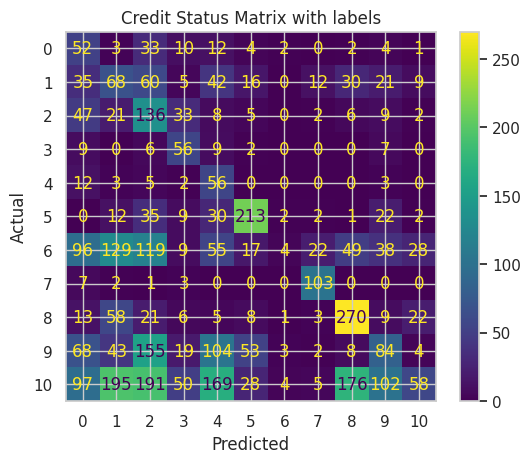

In [ ]:
clf2 = DecisionTreeClassifier(max_depth=7,  class_weight='balanced')
clf2.fit(X_train, y_train)
y_pred = clf2.predict(X_test)
probs = clf2.predict_proba(X_test)[:,1]

train_probs = clf2.predict_proba(X_train)[:,1]
train_predictions = clf2.predict(X_train)
cm = confusion_matrix(y_train, train_predictions)
print('TRAIN')
print('Accuracy: %.2f' % (accuracy_score(y_train, train_predictions)))
print('f1_score: %.2f' % (f1_score(y_train, train_predictions,average="macro")))

print('TEST')
cm = confusion_matrix(y_test, y_pred)
#общая точность
print('Accuracy: %.2f' % (accuracy_score(y_test, y_pred)))
# print('K-accuracy: %.2f' % (top_k_accuracy_score(y_test, y_pred)))
print('f1_score: %.2f' % (f1_score(y_test, y_pred,average="macro")))
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['0','1','2','3','4','5','6','7','8','9','10'])
cmd_obj.plot()
cmd_obj.ax_.set(
                title='Credit Status Matrix with labels',
                xlabel='Predicted',
                ylabel='Actual')
plt.show();

Ага, а кажется баланс классов делает только хуже. Сделаем грид-серч без него. И без ограничения числа фич (с ограничением дало также accuracy 0.44)

In [ ]:
parameters_grid = {
    'min_samples_split' : [2, 3, 4, 5, 7, 10],
    'max_depth': np.arange(4, 15, 1),
    'min_samples_leaf': [1, 2, 3, 4, 5, 7, 10]
}

lr = DecisionTreeClassifier()
# cv = StratifiedKFold(n_splits=3, shuffle=True)
grid_cv = GridSearchCV(lr, parameters_grid,
                       scoring='accuracy', cv=2, verbose=0)
grid_cv.fit(X_train, y_train);
print(grid_cv.best_score_)
print(grid_cv.best_params_)
best_params = grid_cv.best_params_

model = DecisionTreeClassifier(**best_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
probs = model.predict_proba(X_test)[:,1]

train_probs = model.predict_proba(X_train)[:,1]
train_predictions = model.predict(X_train)

print('Accuracy: %.2f' % (accuracy_score(y_test, y_pred)))

0.4166026455886287
{'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 10}
Accuracy: 0.45


Ура, секрет раскрыт!

##### Еще проверим модель и grid на данных с бинарной instrumentalness

In [ ]:
X = data.drop(columns=['instrumentalness', 'Class'])
y = data['Class']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [ ]:
parameters_grid = {
    'min_samples_split' : [2, 3, 4, 5, 7, 10],
    'max_depth': np.arange(4, 15, 1),
    'min_samples_leaf': [1, 2, 3, 4, 5, 7, 10]
}

lr = DecisionTreeClassifier()
# cv = StratifiedKFold(n_splits=3, shuffle=True)
grid_cv = GridSearchCV(lr, parameters_grid,
                       scoring='accuracy', cv=2, verbose=0)
grid_cv.fit(X_train, y_train);
print(grid_cv.best_score_)
print(grid_cv.best_params_)
best_params = grid_cv.best_params_

model = DecisionTreeClassifier(**best_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
probs = model.predict_proba(X_test)[:,1]

train_probs = model.predict_proba(X_train)[:,1]
train_predictions = model.predict(X_train)

print('Accuracy: %.2f' % (accuracy_score(y_test, y_pred)))

0.4131864116210073
{'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 10}
Accuracy: 0.44


TRAIN
Accuracy: 0.48
f1_score: 0.39
TEST
Accuracy: 0.44
f1_score: 0.34


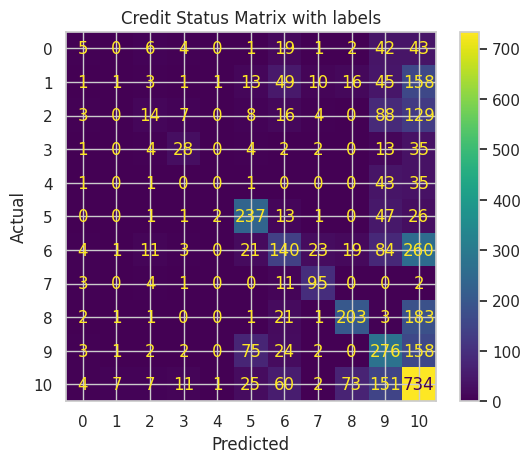

In [ ]:
clf3 = DecisionTreeClassifier(**grid_cv.best_params_)
clf3.fit(X_train, y_train)
y_pred = clf3.predict(X_test)
probs = clf3.predict_proba(X_test)[:,1]

train_probs = clf3.predict_proba(X_train)[:,1]
train_predictions = clf3.predict(X_train)
cm = confusion_matrix(y_train, train_predictions)
print('TRAIN')
print('Accuracy: %.2f' % (accuracy_score(y_train, train_predictions)))
print('f1_score: %.2f' % (f1_score(y_train, train_predictions,average="macro")))

print('TEST')
cm = confusion_matrix(y_test, y_pred)
#общая точность
print('Accuracy: %.2f' % (accuracy_score(y_test, y_pred)))
# print('K-accuracy: %.2f' % (top_k_accuracy_score(y_test, y_pred)))
print('f1_score: %.2f' % (f1_score(y_test, y_pred,average="macro")))
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['0','1','2','3','4','5','6','7','8','9','10'])
cmd_obj.plot()
cmd_obj.ax_.set(
                title='Credit Status Matrix with labels',
                xlabel='Predicted',
                ylabel='Actual')
plt.show();

Лучших результатов такой заменой добиться не удалось

### Задание 3. Другие модели (без баллов, просто если есть желание)

Проделайте операции из **Задания 2** с другими известными вам классификаторами. Стало ли лучше?

In [ ]:
# X['key'] = X['key'].cat.add_categories('0')
# X['key'].fillna('0', inplace =True)
X = data.drop(columns=['instrumentalness_classes', 'Class'])

y = data['Class']
#обязательно ставим stratify, чтобы и в train и в test было одинаковое распределение классов
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

TRAIN
Accuracy: 0.93
f1_score: 0.95
TEST
Accuracy: 0.46
f1_score: 0.42


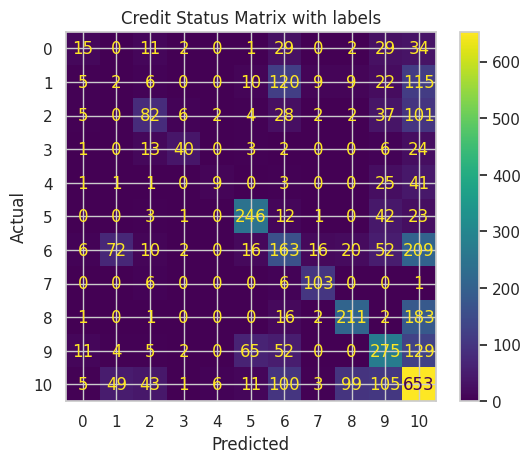

In [ ]:
model = RandomForestClassifier(class_weight = 'balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
probs = model.predict_proba(X_test)[:,1]

train_probs = model.predict_proba(X_train)[:,1]
train_predictions = model.predict(X_train)
cm = confusion_matrix(y_train, train_predictions)
print('TRAIN')
print('Accuracy: %.2f' % (accuracy_score(y_train, train_predictions)))
print('f1_score: %.2f' % (f1_score(y_train, train_predictions,average="macro")))

print('TEST')
cm = confusion_matrix(y_test, y_pred)
#общая точность
print('Accuracy: %.2f' % (accuracy_score(y_test, y_pred)))
print('f1_score: %.2f' % (f1_score(y_test, y_pred,average="macro")))

cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['0','1','2','3','4','5','6','7','8','9','10'])
cmd_obj.plot()
cmd_obj.ax_.set(
                title='Credit Status Matrix with labels',
                xlabel='Predicted',
                ylabel='Actual')
plt.show();

Очевидно, что рандомный лес сработал чуть лучше. При этом лучше для сбалансированных классов, ура! Но если честно, то желание есть, а времени - нет! Но если у вас есть ноутбук с бест практис по ещё другим моделям, было бы круто, если ими можно было бы со мной и другими ребятами поделиться!

### Задание 4. (0.5 доп. балла)

Расскажите про свои любимые фильмы, мультики и тд.

1. https://www.youtube.com/watch?v=SzGNgTof5QQ&ab_channel=InstructiveStories - мультик на почти целых пять минут, который очень помогает когда тяжело и грустно :)

2. Стражи Галактики 3 - очень хорошо раскрывают тему не гуманного отношения к животным (и не только)

3. Наверное, мультфильм "Легенда об Аанге" - очень по-доброму учит быть стойким, не сдаваться, верить в себя и в окружающий мир и людей вокруг

Вообще выбрать три сложно - потому что хороших фильмов и мультиков очень много :) Например недавно вышедший Мастер и Маргарита тоже очень хорош. А если у вас есть время и ресурсы на что-то серьезное - есть крутой фильм Лобстер - заставляет задуматься о том, на сколько общество предопределяет человека.